## Lexical complexity prediction using deep learning

In [1]:
import random
import numpy as np
import torch

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import pandas as pd

In [4]:
LP = pd.read_csv("lcp_single_train.tsv", sep='\t')

## Missing Values

In [5]:
LP = LP.dropna(subset=['sentence', 'token', 'complexity'])

In [6]:
#converting to string using .loc
LP.loc[:, 'sentence'] = LP['sentence'].astype(str)
LP.loc[:, 'token'] = LP['token'].astype(str)

## EDA

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

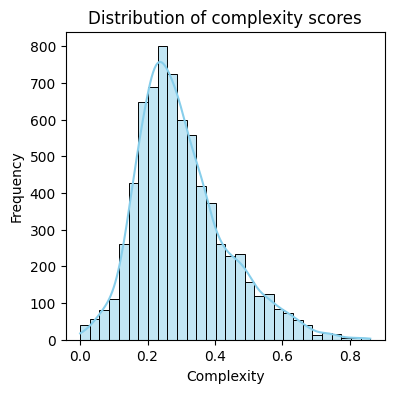

In [8]:
#distribution of complexity scores
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(LP['complexity'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of complexity scores")
plt.xlabel("Complexity")
plt.ylabel("Frequency")

Text(0.5, 0, 'Complexity')

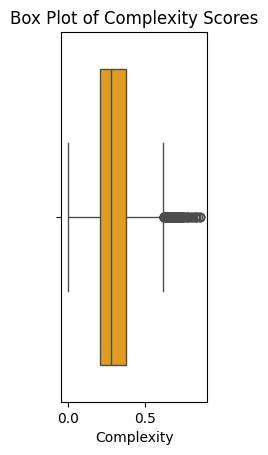

In [9]:
#Box plot
plt.subplot(1, 3, 2)
sns.boxplot(x=LP['complexity'], color='orange')
plt.title("Box Plot of Complexity Scores")
plt.xlabel("Complexity")

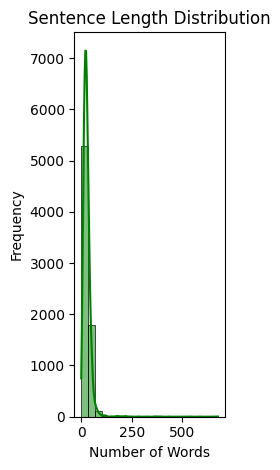

In [10]:
# Sentence Length Distribution
LP['sentence_length'] = LP['sentence'].apply(lambda x: len(x.split()))
plt.subplot(1, 3, 3)
sns.histplot(LP['sentence_length'], bins=20, kde=True, color='green')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [11]:
#Adding [TGT] tags
def mark_target(row):
    sentence = row['sentence']
    token = row['token']
    if token in sentence:
        return sentence.replace(token, f"[TGT] {token} [TGT]", 1)
    else:
        return f"[TGT] {token} [TGT] " + sentence

In [12]:
LP.loc[:, 'input'] = LP.apply(mark_target, axis=1)

In [13]:
LP[['input', 'token', 'complexity']].head()

,input,token,complexity
0,"Behold, there came up out of the [TGT] river [...",river,0.000000
1,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,He has put my brothers far from me.\tbrothers\...,sons,0.055556


In [14]:
#Removing tabs
LP['input'] = LP['input'].str.replace(r'[\t\n\r\\]', ' ', regex=True)

In [15]:
LP[['input', 'token', 'complexity']].head()

,input,token,complexity
0,"Behold, there came up out of the [TGT] river [...",river,0.000000
1,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,He has put my brothers far from me. brothers 0...,sons,0.055556


In [16]:
LP[['input', 'token', 'complexity']].tail()

,input,token,complexity
7227,Since certain comments have been made on this ...,Shanks,0.656250
7228,The struggle against global Islamic terrorism ...,jurisprudence,0.671875
7229,The reason I was slightly late was that I was ...,Emir,0.675000
7230,There is apparently here in this Parliament a ...,Quod,0.678571
7231,"It is a moment of important reflection, introd...",paedophiles,0.680556


## Model 1- RoBERTa Model


In [17]:
!pip install transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [18]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

## Train-Validation Split 80/20

In [19]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    LP['input'].tolist(), LP['complexity'].tolist(), test_size=0.2, random_state=SEED
)

In [20]:
# HuggingFace Dataset
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
validate_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

## Roberta Tokenizer

In [21]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [22]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

In [23]:
train_dataset = train_dataset.map(tokenize, batched=True)
validate_dataset = validate_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/5780 [00:00<?, ? examples/s]

Map:   0%|          | 0/1445 [00:00<?, ? examples/s]

In [25]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validate_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

## LOading model

In [26]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Hugging Face Trainer for fine-tuning
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=10,
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.012700,0.008740


Epoch,Training Loss,Validation Loss
1,0.012700,0.008740
2,0.010100,0.007186
3,0.009000,0.007089
4,0.008600,0.006767


TrainOutput(global_step=1448, training_loss=0.01144167767240774, metrics={'train_runtime': 549.9574, 'train_samples_per_second': 42.04, 'train_steps_per_second': 2.633, 'total_flos': 1520768245493760.0, 'train_loss': 0.01144167767240774, 'epoch': 4.0})

## Results

In [29]:
model.eval()
predictions = trainer.predict(validate_dataset)
preds = predictions.predictions.flatten()
true = predictions.label_ids

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

In [32]:
mse = mean_squared_error(true, preds)
print("Mean square error:", mse)
print("Pearson Correlation:", stats.pearsonr(preds, true)[0])
print("Mean absoulte error:", mean_absolute_error(true, preds))
print("R² Score:", r2_score(true, preds))

Mean square error: 0.006767150945961475
Pearson Correlation: 0.8062684340877979
Mean absoulte error: 0.0645652562379837
R² Score: 0.6451267004013062


## Model 2-Distilbert model

In [33]:
import random
import numpy as np
import torch

In [34]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [35]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

## Tokenization

In [36]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [37]:
def tokenize_data(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

In [38]:
train_dataset = train_dataset.map(tokenize_data, batched=True)
val_dataset = validate_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/5780 [00:00<?, ? examples/s]

Map:   0%|          | 0/1445 [00:00<?, ? examples/s]

In [39]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validate_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

## Load Model

In [40]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from transformers import TrainingArguments, Trainer

## DistilBERT training setup using trainer API

In [42]:
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=10,
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Model Training

In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.010500,0.008573
2,0.006200,0.008374
3,0.006100,0.007085


TrainOutput(global_step=1086, training_loss=0.009217514517557555, metrics={'train_runtime': 207.533, 'train_samples_per_second': 83.553, 'train_steps_per_second': 5.233, 'total_flos': 574235932308480.0, 'train_loss': 0.009217514517557555, 'epoch': 3.0})

## Results

Predictions

In [44]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [45]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.flatten()
true = predictions.label_ids

In [46]:
import numpy as np

In [47]:
preds = np.clip(preds, 0, 1)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

metrics

In [49]:
print("MSE:", mean_squared_error(true, preds))
print("MAE:", mean_absolute_error(true, preds))
print("R² Score:", r2_score(true, preds))
print("Pearson Correlation:", stats.pearsonr(preds, true)[0])

MSE: 0.007084520533680916
MAE: 0.06572648137807846
R² Score: 0.6284836530685425
Pearson Correlation: 0.7949629980615924


## Model 3 - BiLSTM with Attention

In [50]:
!pip install keras tensorflow -q

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split

In [53]:
SEED = 42
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [54]:
texts = LP['input'].tolist()
labels = LP['complexity'].values

## Train-Test Split

In [55]:
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

Tokenization

In [56]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

Converting text to sequences

In [57]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

Pad Sequence

In [58]:
max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

Attention Layer for model 3

In [59]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

Pretrained gloVe word embeddings

In [60]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-08 20:46:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 20:46:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 20:46:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [61]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

GloVe-Based BiLSTM with Attention

In [62]:
input_layer = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False)(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Attention()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

model_glove = Model(inputs=input_layer, outputs=output_layer)
model_glove.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_glove.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 100)             │       1,483,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 256)                 │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,734,415 (6.62 MB)

 Trainable params: 251,315 (981.70 KB)

 Non-trainable params: 1,483,100 (5.66 MB)

## Training of Model

In [63]:
history_glove = model_glove.fit(X_train_pad, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_data=(X_val_pad, y_val),
                                verbose=1)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0292 - mae: 0.1310 - val_loss: 0.0208 - val_mae: 0.1072
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0190 - mae: 0.1059 - val_loss: 0.0164 - val_mae: 0.0960
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0160 - mae: 0.0956 - val_loss: 0.0119 - val_mae: 0.0813
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0119 - mae: 0.0834 - val_loss: 0.0105 - val_mae: 0.0775
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0101 - mae: 0.0767 - val_loss: 0.0104 - val_mae: 0.0782
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.0744 - val_loss: 0.0100 - val_mae: 0.0761
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0088 - mae: 0.0719 - val_loss: 0.0098 - val_mae: 0.0757
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0080 - mae: 0.0691 - val_loss: 0.0099 - val_mae: 0.0758
Epoch 9/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/

## Results

In [64]:
y_pred_glove = model_glove.predict(X_val_pad).flatten()
y_pred_glove = np.clip(y_pred_glove, 0, 1)

print("MSE:", mean_squared_error(y_val, y_pred_glove))
print("MAE:", mean_absolute_error(y_val, y_pred_glove))
print("R² Score:", r2_score(y_val, y_pred_glove))
print("Pearson Correlation:", stats.pearsonr(y_val, y_pred_glove)[0])

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.010263519523527775
MAE: 0.07678683951328001
R² Score: 0.46177509449363596
Pearson Correlation: 0.7026230032323666


## Model -04 Albert-base-v2

In [65]:
import random
import numpy as np
import torch

In [66]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [67]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

In [68]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [69]:
def tokenize_albert(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

In [70]:
train_dataset = train_dataset.map(tokenize_albert, batched=True)
val_dataset = val_dataset.map(tokenize_albert, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/5780 [00:00<?, ? examples/s]

Map:   0%|          | 0/1445 [00:00<?, ? examples/s]

In [71]:
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=1)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
from transformers import TrainingArguments, Trainer

In [73]:
training_args = TrainingArguments(
    output_dir='./albert_results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=10,
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.019500,0.016708
2,0.010300,0.011903
3,0.007400,0.008593
4,0.006100,0.007700


TrainOutput(global_step=1448, training_loss=0.015645795146734018, metrics={'train_runtime': 562.4354, 'train_samples_per_second': 41.107, 'train_steps_per_second': 2.575, 'total_flos': 138117373685760.0, 'train_loss': 0.015645795146734018, 'epoch': 4.0})

## Results

In [75]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.flatten()
true = predictions.label_ids

In [76]:
import numpy as np
preds = np.clip(preds, 0, 1)


In [77]:
print("MSE:", mean_squared_error(true, preds))
print("MAE:", mean_absolute_error(true, preds))
print("R² Score:", r2_score(true, preds))
print("pearson correlation:", stats.pearsonr(preds, true)[0])

MSE: 0.007700086571276188
MAE: 0.06766020506620407
R² Score: 0.5962029695510864
pearson correlation: 0.7729136889059198


## Visualisation

In [78]:
#Model-1

In [79]:
import matplotlib.pyplot as plt
import numpy as np

In [80]:
#dataframe
data = {
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "MSE": [0.006925962865352631, 0.007170915603637695, 0.010263519208464881, 0.008414403535425663],
    "MAE": [0.06532153487205505, 0.06614823639392853, 0.07678683813144223, 0.07092108577489853],
    "R2 Score": [0.6367985010147095, 0.6239530444145203, 0.46177511101571644, 0.5587437748908997],
    "Pearson Correlation": [0.8014024778476525, 0.7935019120340172, 0.7026229967467534, 0.7508233155005781]
}

In [81]:
LP = pd.DataFrame(data)

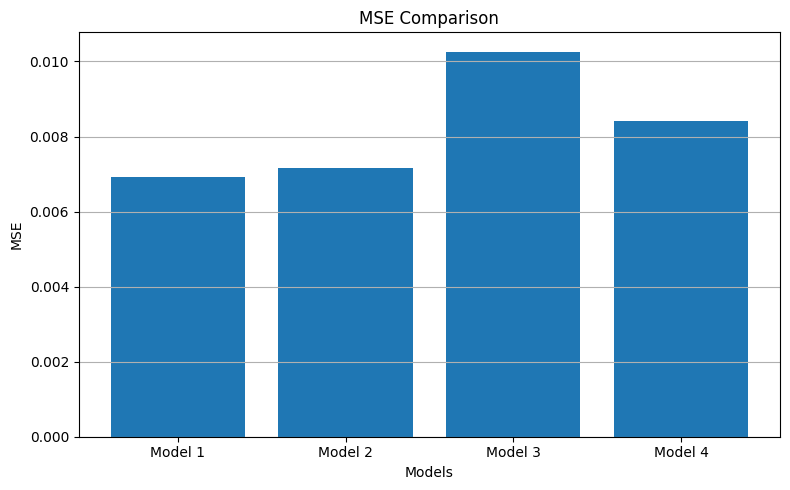

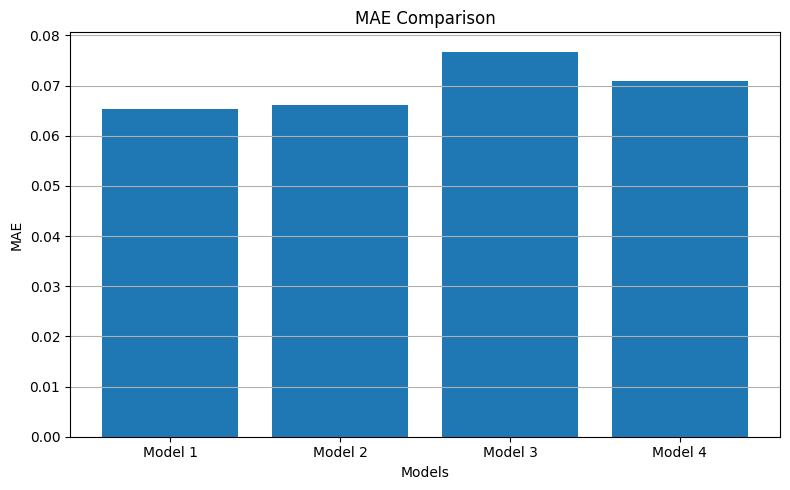

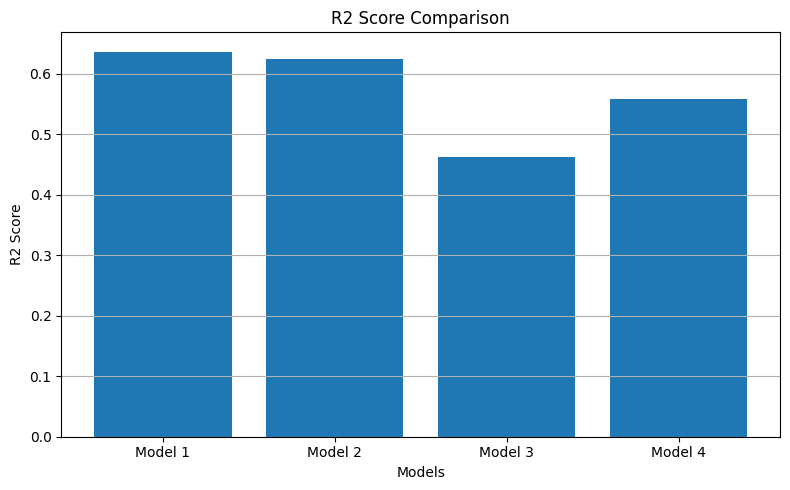

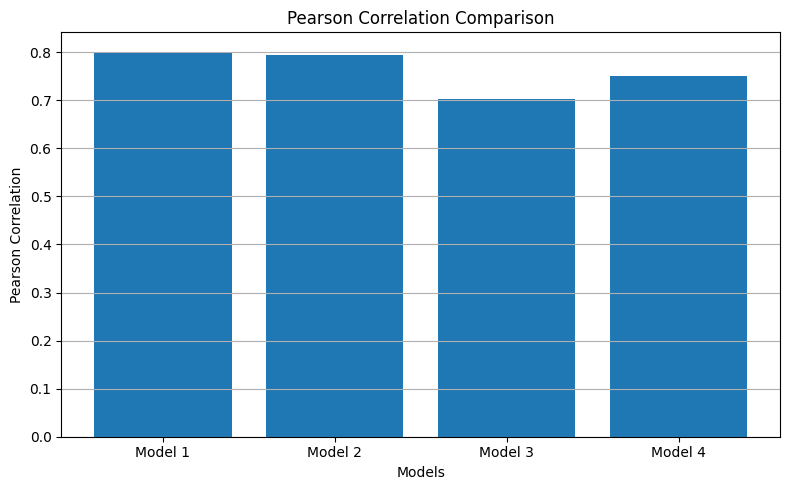

In [83]:
# bar plot
metrics = ["MSE", "MAE", "R2 Score", "Pearson Correlation"]
figs = []

for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(LP["Model"], LP[metric])
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#predicted vs actual plot model-01

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
true_values = true
predicted_values = preds

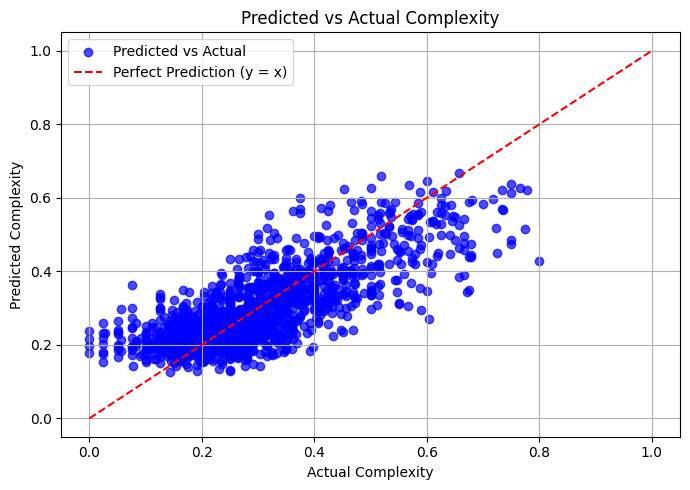

In [86]:
plt.figure(figsize=(7, 5))
plt.scatter(true_values, predicted_values, color='blue', alpha=0.7, label="Predicted vs Actual")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect Prediction (y = x)")
plt.xlabel("Actual Complexity")
plt.ylabel("Predicted Complexity")
plt.title("Predicted vs Actual Complexity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

error distribution plot

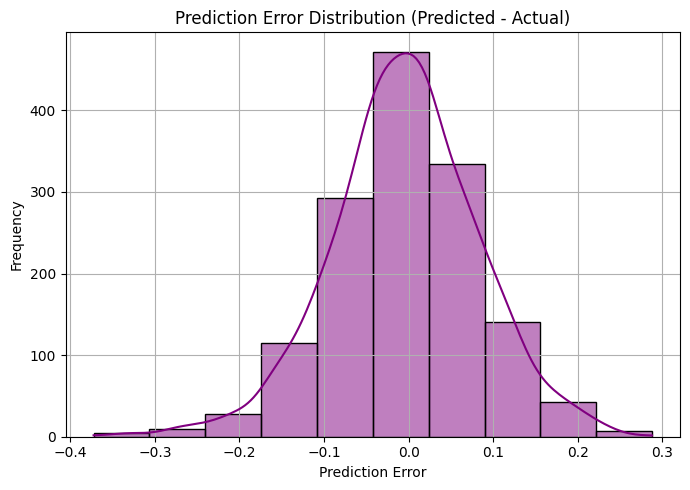

In [87]:
errors = predicted_values - true_values
plt.figure(figsize=(7, 5))
sns.histplot(errors, bins=10, kde=True, color='purple')
plt.title("Prediction Error Distribution (Predicted - Actual)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()